In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pylab import rcParams
from matplotlib.patches import RegularPolygon
from matplotlib.collections import PatchCollection

import math
import os

In [7]:
tc2words = pd.read_csv('../data/ECON_TC_to_bits.csv')
tc2words.columns = ['occupancy', 'words', 'elinks']
tc2words.set_index('occupancy', inplace=True)

def word_count(row):
    ntc = row.ntc
    return tc2words.loc[ntc]['words']

def link_count(row):
    ntc = row.ntc
    return tc2words.loc[ntc]['elinks']

def words_count_interp(row):
    ntc = row.mean_occupancy
    words = np.interp(ntc, tc2words.reset_index().occupancy, tc2words.reset_index().words)
    return words

In [25]:
version = 'TT_TuneCP5_14TeV-powheg-pythia8_Phase2HLTTDRWinter20DIGI-PU200_110X_mcRun4_realistic_v3-v2_thresholdmap_signaldrivencapped'
input_file_template = '../scripts/results/occupancies_{}.csv'
input_file = input_file_template.format(version)
df = pd.read_csv(input_file)
df = df[df.threshold==0.5]
df['occupancy_overhead'] = np.minimum(df['mean_occupancy']*1.3,48)
df['words'] = df.apply(words_count_interp, axis=1)
df['words_overhead'] = np.minimum(df.words*1.3,25)
df['elinks'] = np.ceil(df.words_overhead/2.).astype('int32')
df

threshold  layer  waferu  waferv  mean_occupancy  mean_words  \
0           0.5      1       1       2        2.051492    3.039300   
1           0.5      1       1       3        2.100832    3.087923   
2           0.5      1       1       4        2.055221    3.045754   
3           0.5      1       1       5        2.048623    3.035141   
4           0.5      1       1       6        2.052352    3.039730   
...         ...    ...     ...     ...             ...         ...   
3290        0.5     50       7       2        0.010757    1.010757   
3291        0.5     50       7       3        0.016351    1.016351   
3292        0.5     50       7       4        0.022232    1.022232   
3293        0.5     50       7       5        0.017355    1.017355   
3294        0.5     50       7       6        0.010470    1.010470   

      occupancy_overhead     words  words_overhead  elinks  
0               2.666939  3.051492        3.966939       2  
1               2.731081  3.100832        4.031081       3  
2               2.671787  3.055221        3.971787       2  
3               2.663210  3.048623        3.963210       2  
4               2.668058  3.052352        3.968058       2  
...                  ...       ...             ...     ...  
3290            0.013985  1.010757        1.313985       1  
3291            0.021256  1.016351        1.321256       1  
3292            0.028901  1.022232        1.328901       1  
3293            0.022562  1.017355        1.322562       1  
3294            0.013612  1.010470        1.313612       1  

[3295 rows x 10 columns]

In [26]:
#wafer_size = 166.4408 #mm (see https://github.com/cms-sw/cmssw/blob/master/Geometry/HGCalCommonData/data/hgcal/v14/hgcal.xml) 
wafer_flattoflat = 167.4408 #mm 
wafer_outerradius = wafer_flattoflat/math.sqrt(3)
columns = ['layer', 'shape', 'thickness', 'x', 'y', 'rotation', 'u', 'v']
modules = pd.read_csv('../data/geomnew_corrected_withmult_F_rotations_v11.1.txt', sep=' ', names=columns)
modules.set_index(['layer', 'u', 'v'], inplace=True)
modules

shape  thickness       x      y  rotation
layer u v                                          
1     3 0     F        120   502.3    0.0         0
      4 0     F        120   669.8    0.0         0
      5 0     F        200   837.2    0.0         0
      6 0     F        200  1004.6    0.0         0
      7 0     F        200  1172.1    0.0         0
...         ...        ...     ...    ...       ...
50    7 6     a        300   669.8  773.4         1
        5     b        300   753.5  628.4         1
        4     b        300   837.2  483.4         1
        3     b        300   920.9  338.4         1
        2     a        300  1004.6  193.3         0

[4899 rows x 5 columns]

In [27]:
def x_position(row):
    try:
        x = modules.loc[(row.layer, row.waferu, row.waferv)].x
    except KeyError:
        x = np.nan
    return x

def y_position(row):
    try:
        y = modules.loc[(row.layer, row.waferu, row.waferv)].y
    except KeyError:
        y = np.nan
    return y

In [28]:
df['x'] = df.apply(x_position, axis=1)
df['y'] = df.apply(y_position, axis=1)
df

threshold  layer  waferu  waferv  mean_occupancy  mean_words  \
0           0.5      1       1       2        2.051492    3.039300   
1           0.5      1       1       3        2.100832    3.087923   
2           0.5      1       1       4        2.055221    3.045754   
3           0.5      1       1       5        2.048623    3.035141   
4           0.5      1       1       6        2.052352    3.039730   
...         ...    ...     ...     ...             ...         ...   
3290        0.5     50       7       2        0.010757    1.010757   
3291        0.5     50       7       3        0.016351    1.016351   
3292        0.5     50       7       4        0.022232    1.022232   
3293        0.5     50       7       5        0.017355    1.017355   
3294        0.5     50       7       6        0.010470    1.010470   

      occupancy_overhead     words  words_overhead  elinks       x      y  
0               2.666939  3.051492        3.966939       2     0.0  290.0  
1               2.731081  3.100832        4.031081       3   -83.7  435.0  
2               2.671787  3.055221        3.971787       2  -167.4  580.0  
3               2.663210  3.048623        3.963210       2  -251.2  725.0  
4               2.668058  3.052352        3.968058       2  -334.9  870.0  
...                  ...       ...             ...     ...     ...    ...  
3290            0.013985  1.010757        1.313985       1  1004.6  193.3  
3291            0.021256  1.016351        1.321256       1   920.9  338.4  
3292            0.028901  1.022232        1.328901       1   837.2  483.4  
3293            0.022562  1.017355        1.322562       1   753.5  628.4  
3294            0.013612  1.010470        1.313612       1   669.8  773.4  

[3295 rows x 12 columns]

In [29]:
def plot_sector_links(group):
    patch_list = []
    links = []
    xys = [] 
    group_layer = group.layer.array[0]

    for row in group.iterrows():
        link = int(row[1].elinks)
        links.append(link)
        xys.append((row[1].x, row[1].y))
        patch_list.append(
                RegularPolygon(
                        xy=(row[1].x, row[1].y),
                        numVertices=6,
                        radius=wafer_outerradius,
                        orientation=0.,
                )
        )
    col = PatchCollection(patch_list)
    col.set(array=np.array(links), cmap='viridis')
    col.set_clim([0.5, 8.])

    fig, ax = plt.subplots(dpi=150)

    ax.add_collection(col)
    ax.autoscale()
    ax.axis('equal')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')

    for xy,lk in zip(xys, links):
        plt.text(xy[0]-0.2*wafer_flattoflat, xy[1]-0.05*wafer_flattoflat, f'{lk:d}', fontsize=5, color='white')

    plt.text(0.98, 0.95, 'Layer {0}'.format(group_layer), horizontalalignment='right', transform=ax.transAxes)
    fig.colorbar(col)
    plt.show()

In [38]:
def plot_sector_words(group):
    patch_list = []
    words = []
    xys = [] 
    group_layer = group.layer.array[0]

    for row in group.iterrows():
        word = row[1].words_overhead
        words.append(word)
        xys.append((row[1].x, row[1].y))
        patch_list.append(
                RegularPolygon(
                        xy=(row[1].x, row[1].y),
                        numVertices=6,
                        radius=wafer_outerradius,
                        orientation=0.,
                )
        )
    col = PatchCollection(patch_list)
    col.set(array=np.array(words), cmap='viridis')
    col.set_clim([0., 9.])

    fig, ax = plt.subplots(dpi=150)

    ax.add_collection(col)
    ax.autoscale()
    ax.axis('equal')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')

    for xy,word in zip(xys, words):
        plt.text(xy[0]-0.2*wafer_flattoflat, xy[1]-0.05*wafer_flattoflat, f'{word:4.2f}', fontsize=5, color='white')

    plt.text(0.98, 0.95, 'Layer {0}'.format(group_layer), horizontalalignment='right', transform=ax.transAxes)
    fig.colorbar(col)
    plt.show()

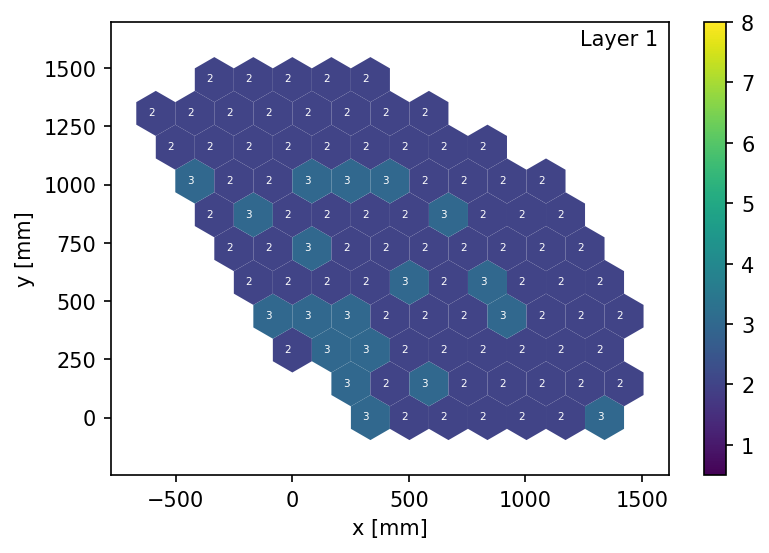

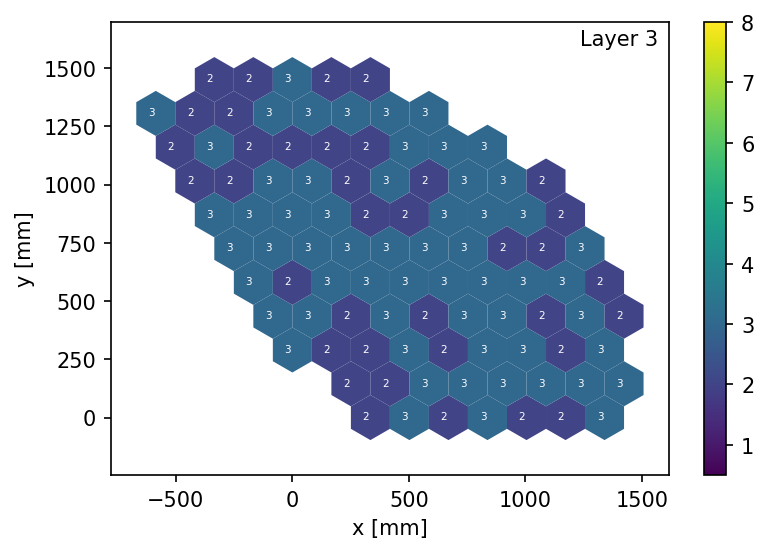

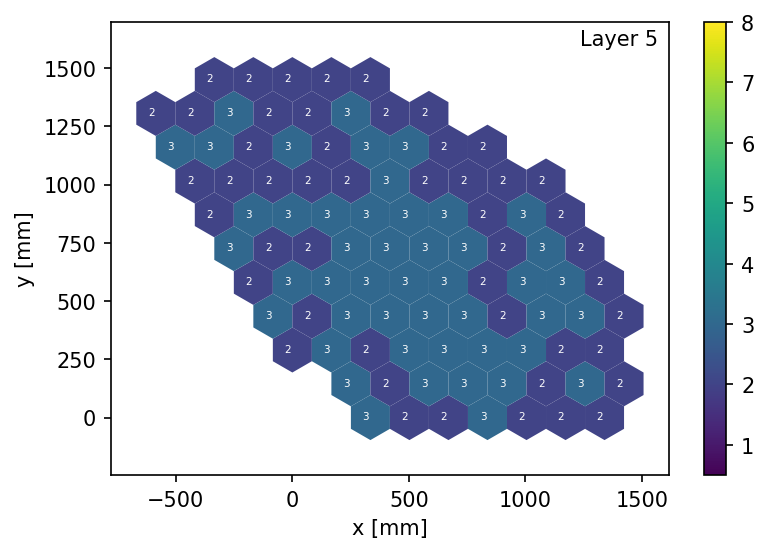

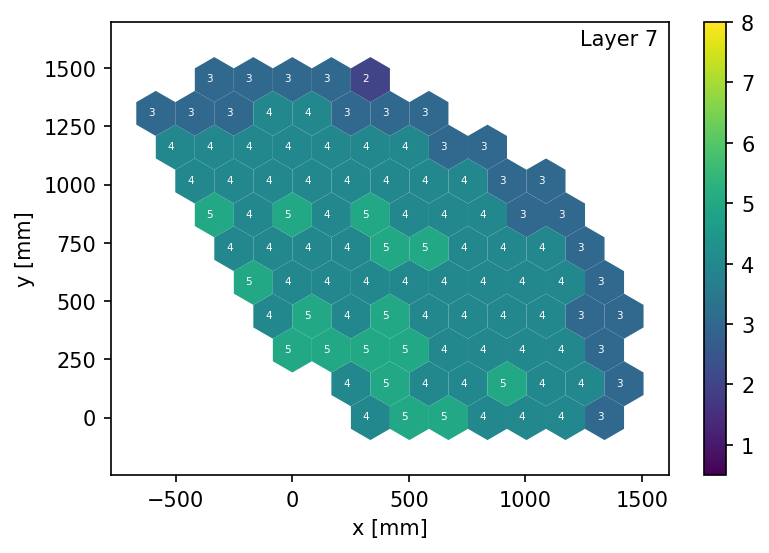

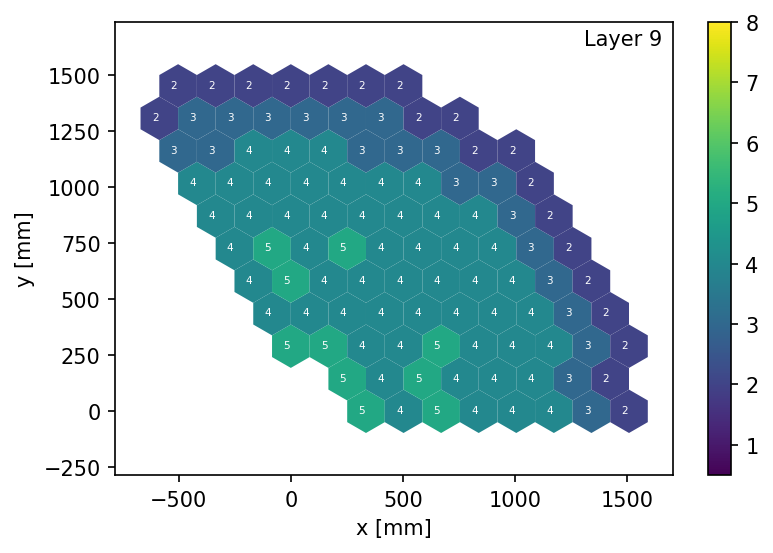

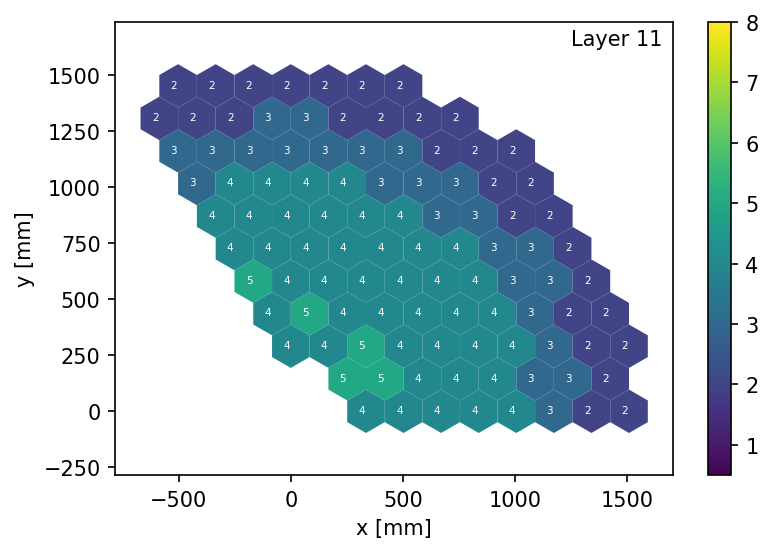

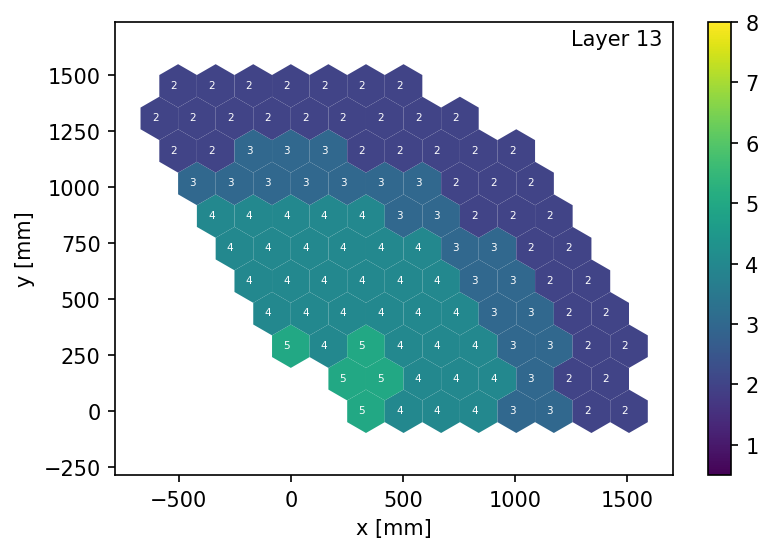

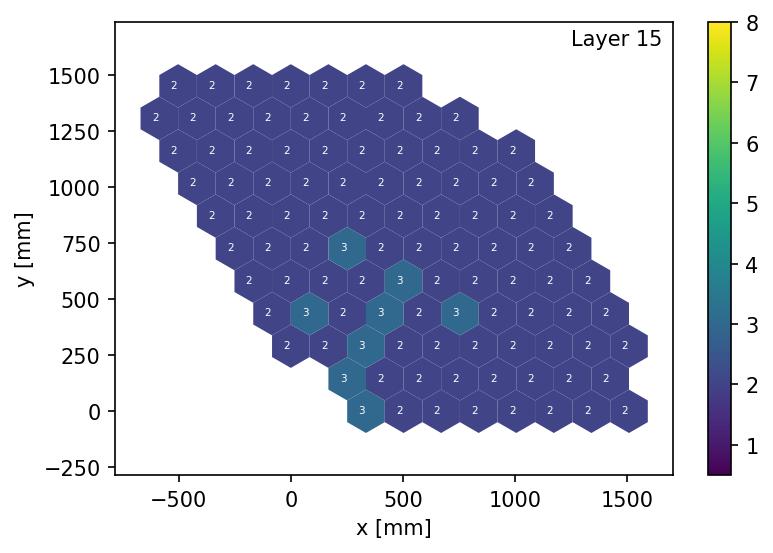

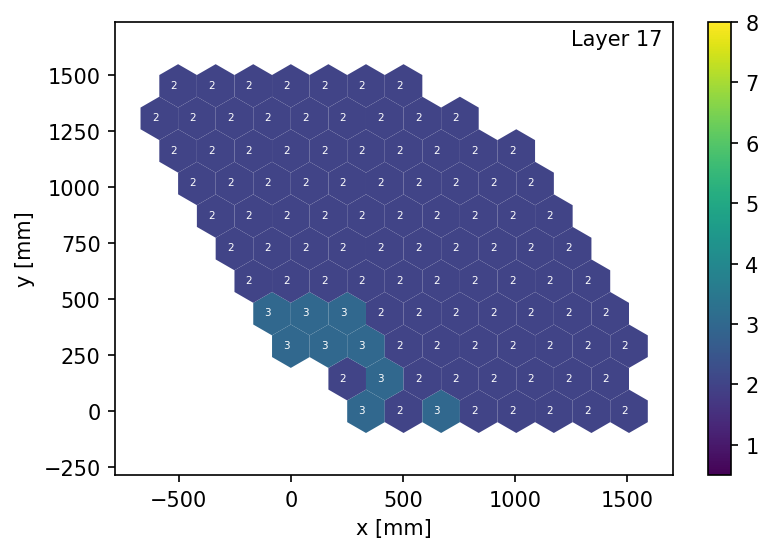

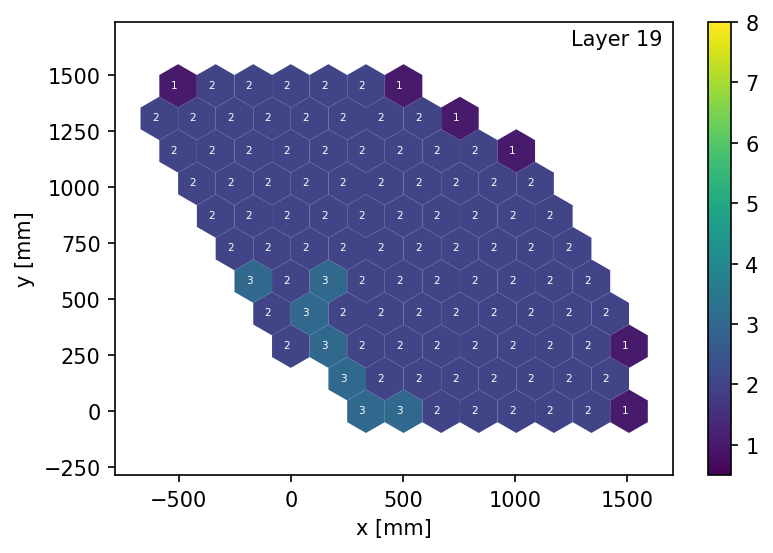

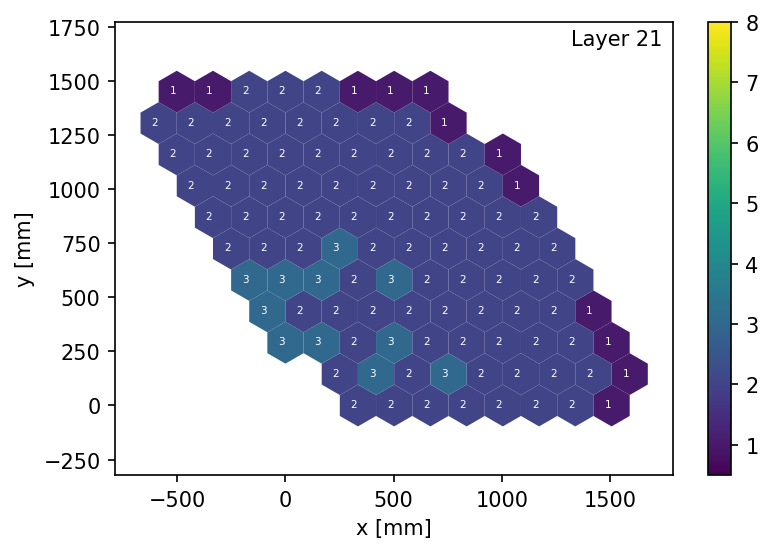

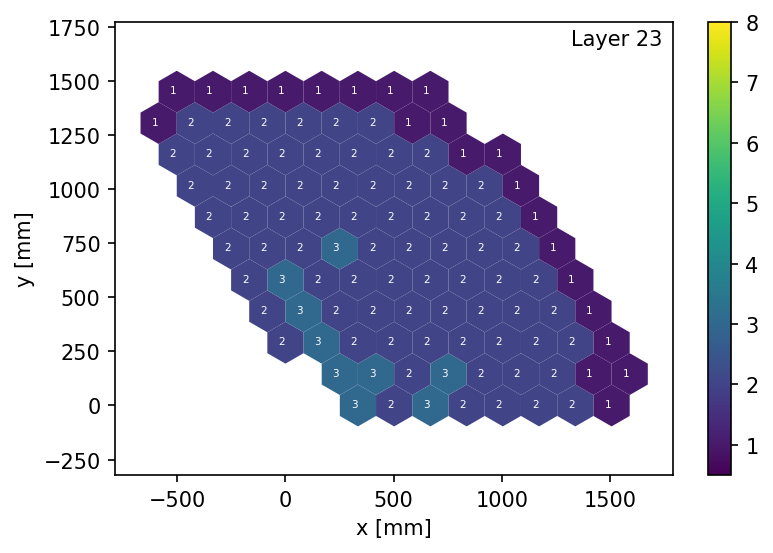

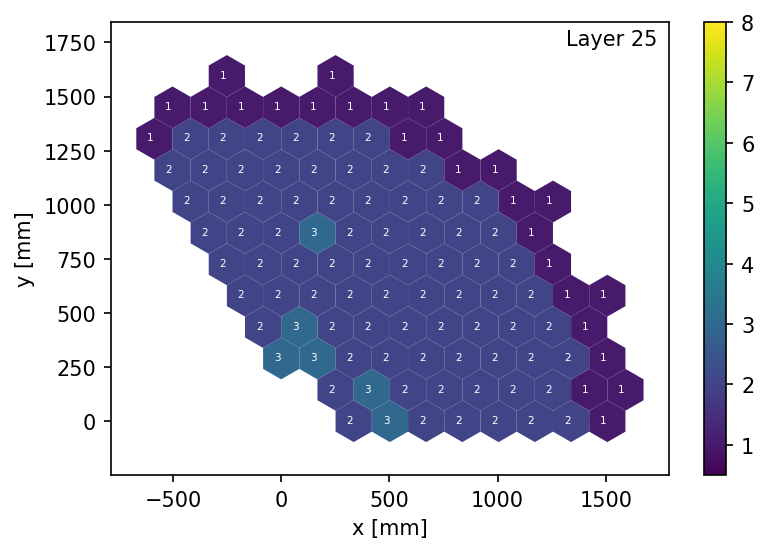

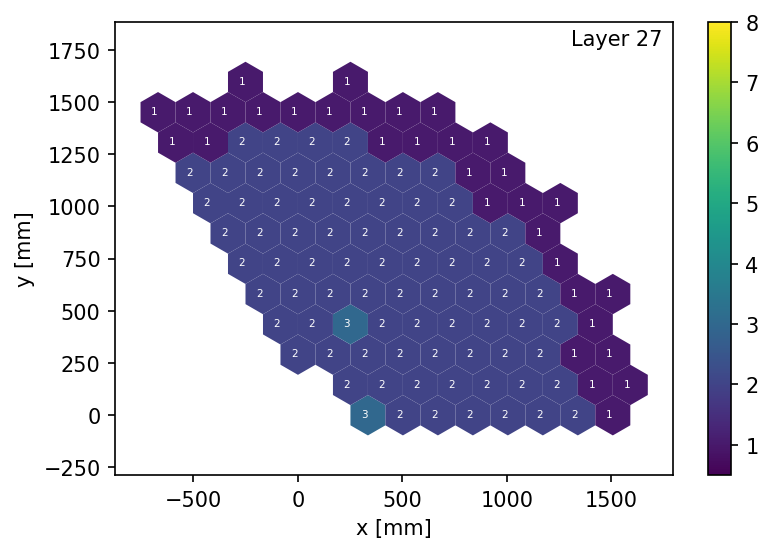

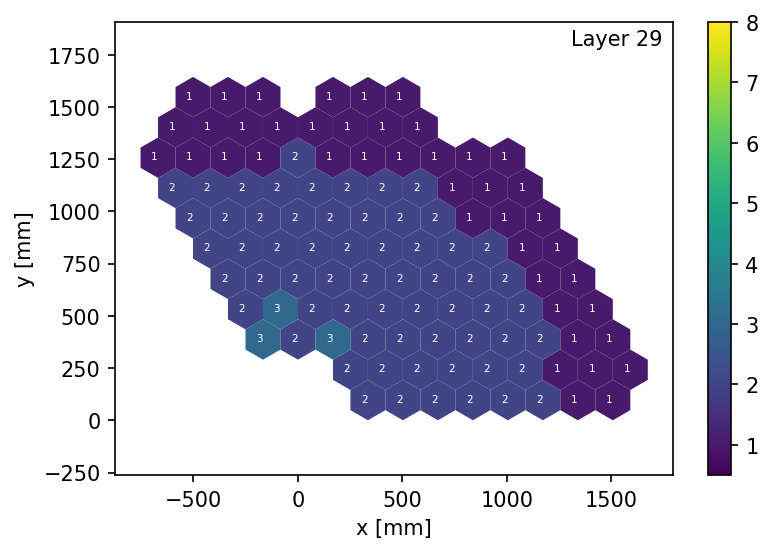

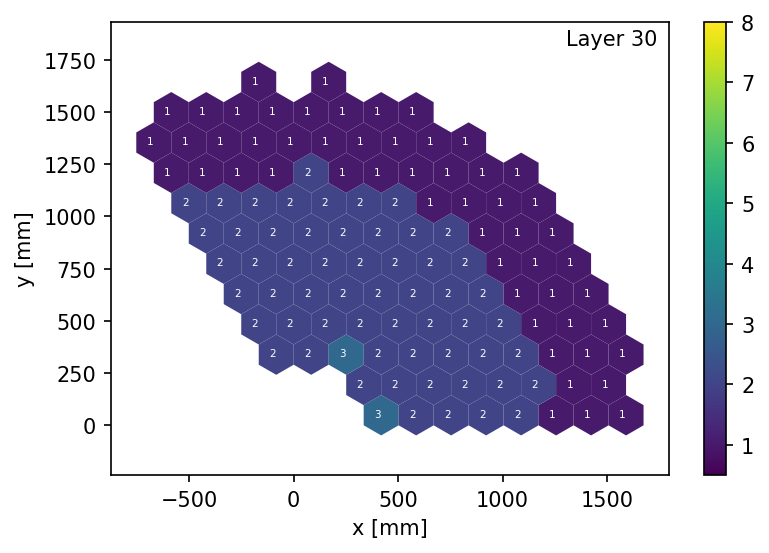

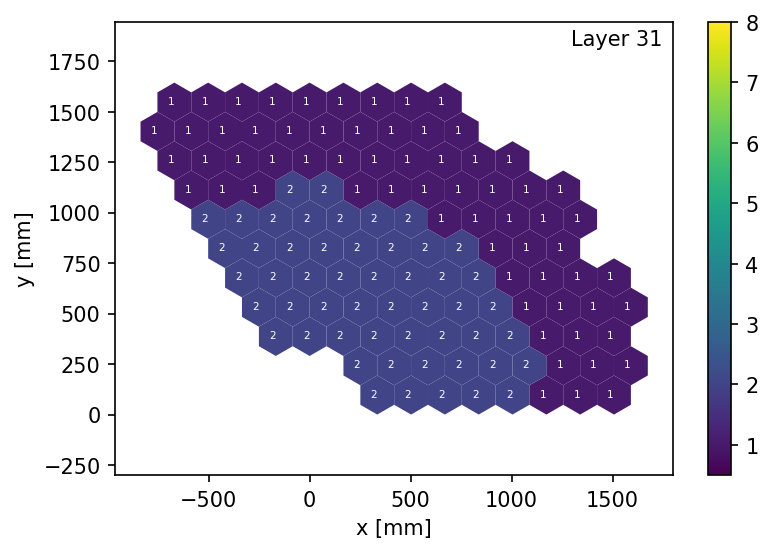

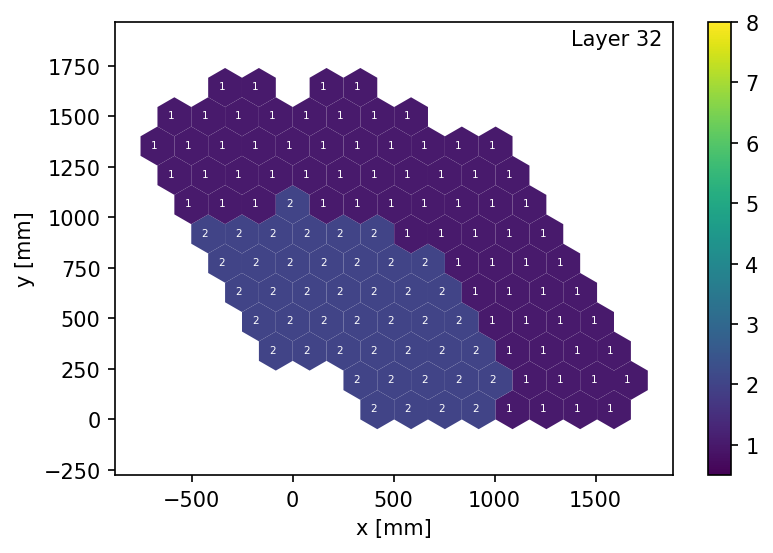

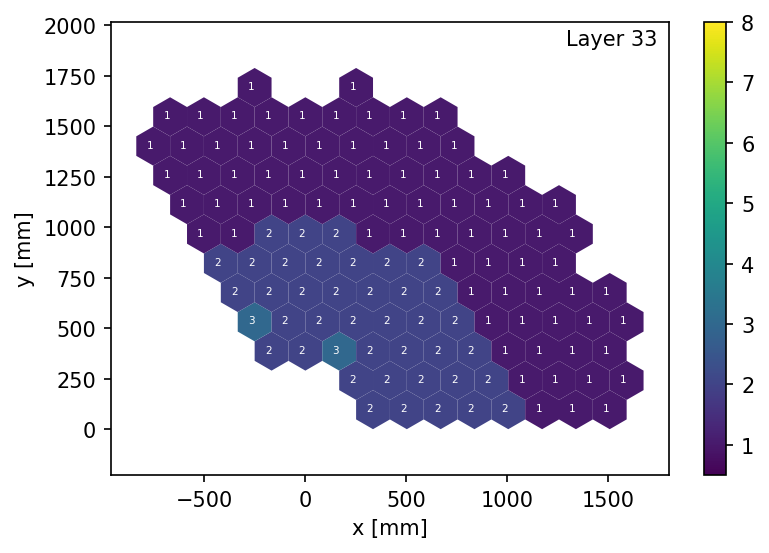

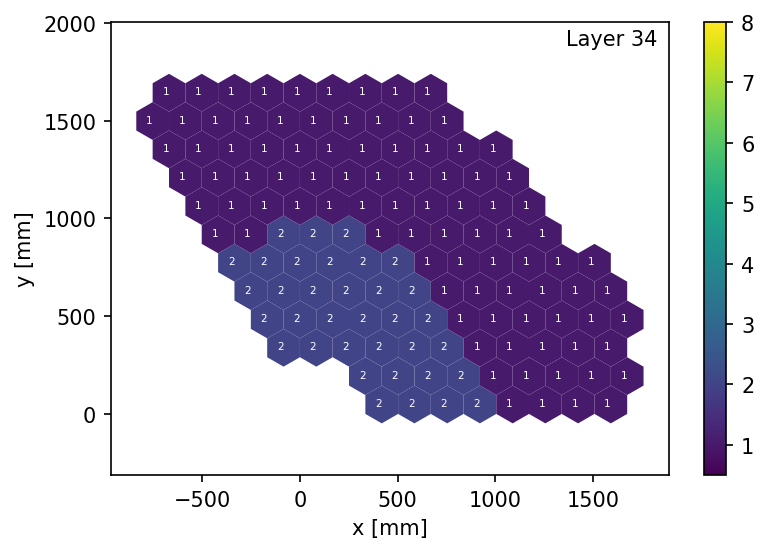

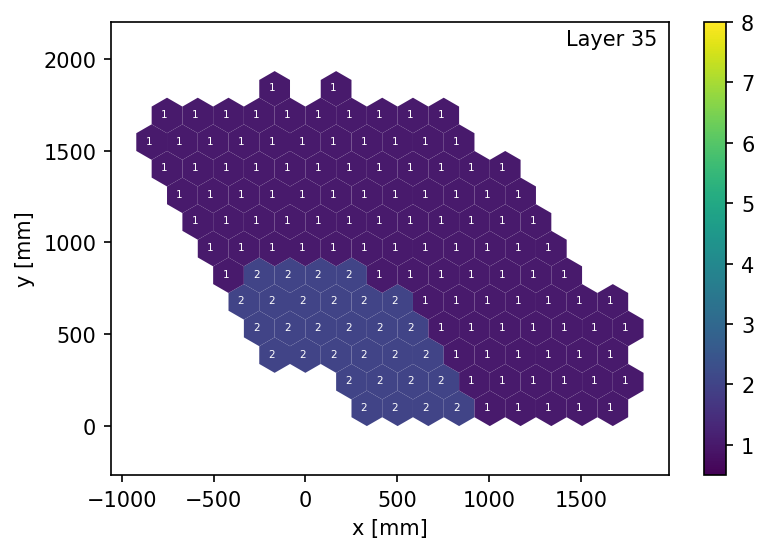

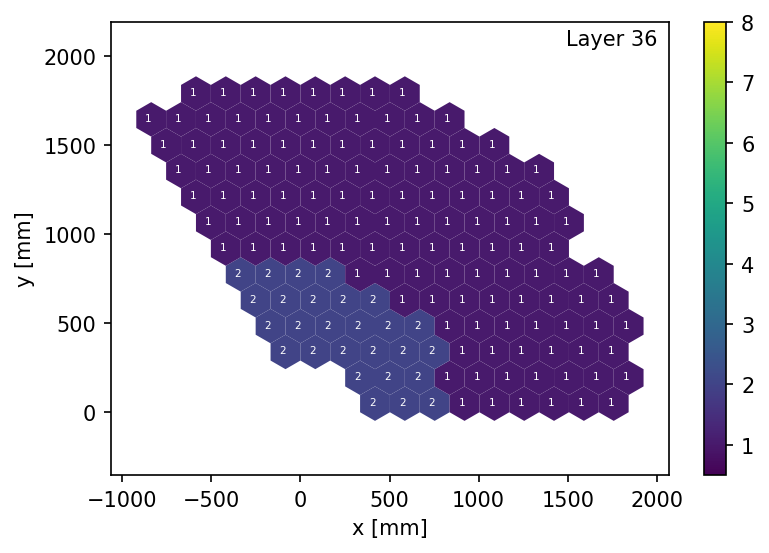

posx and posy should be finite values
posx and posy should be finite values


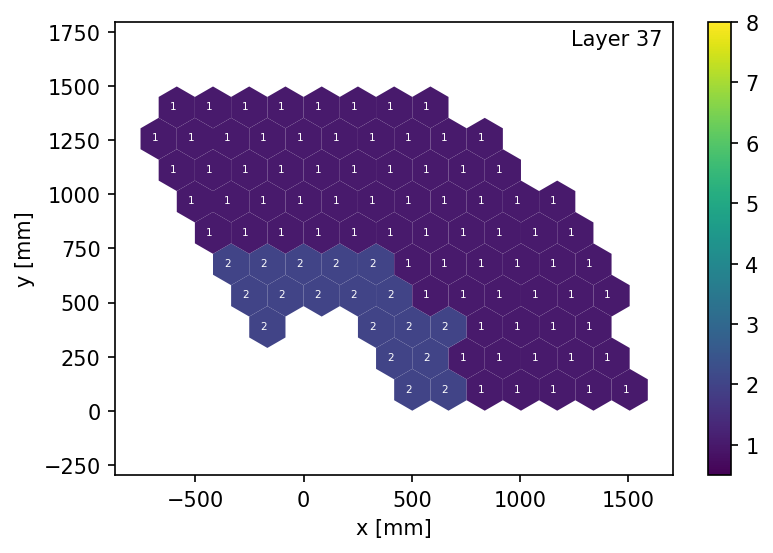

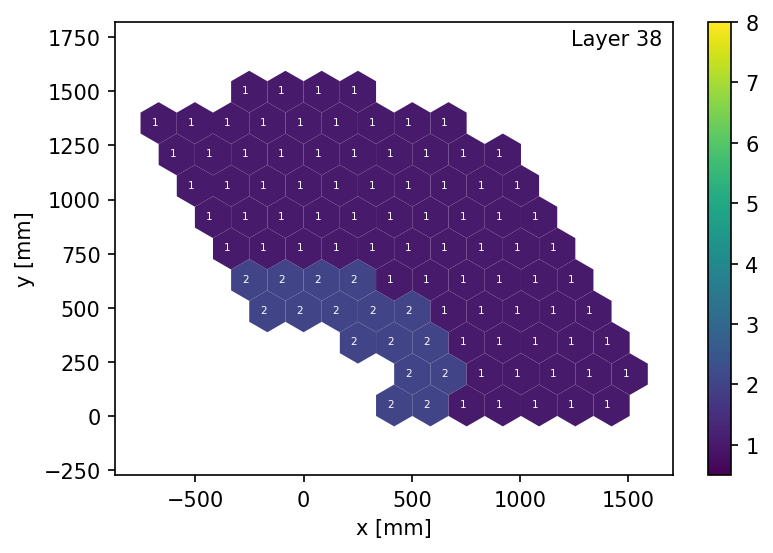

posx and posy should be finite values
posx and posy should be finite values


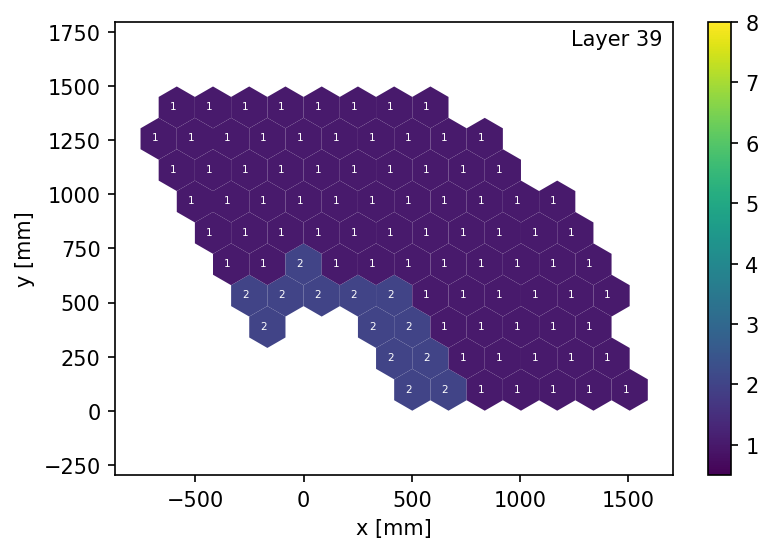

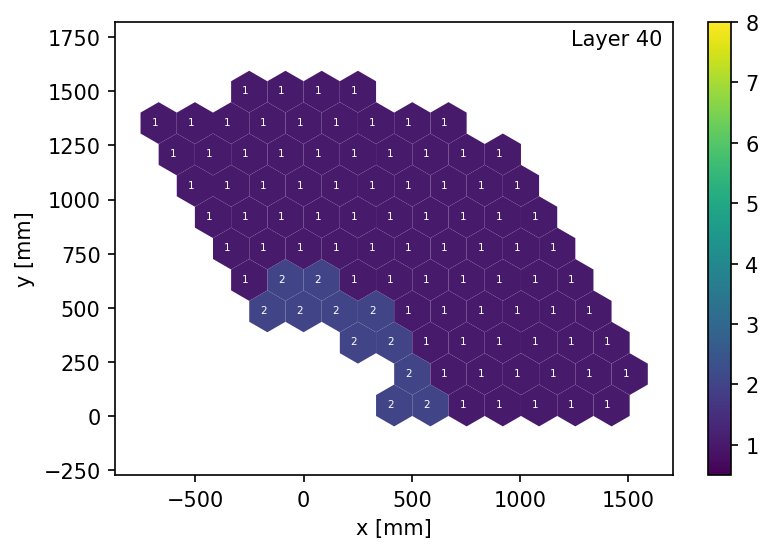

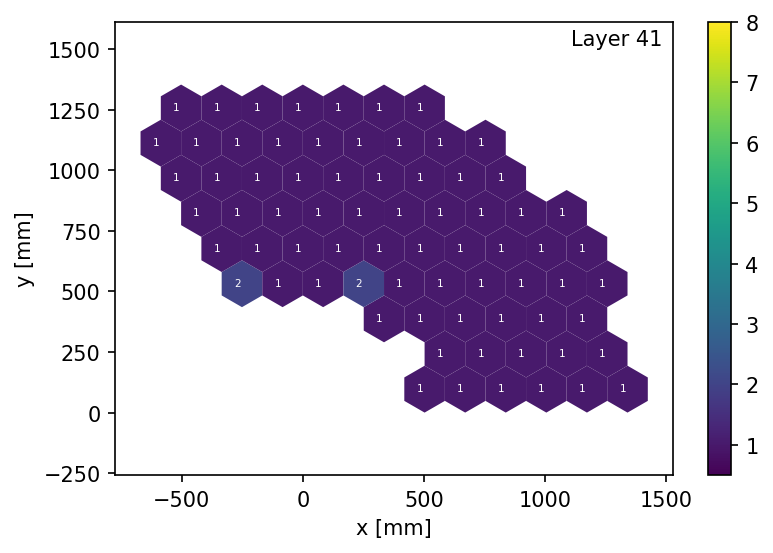

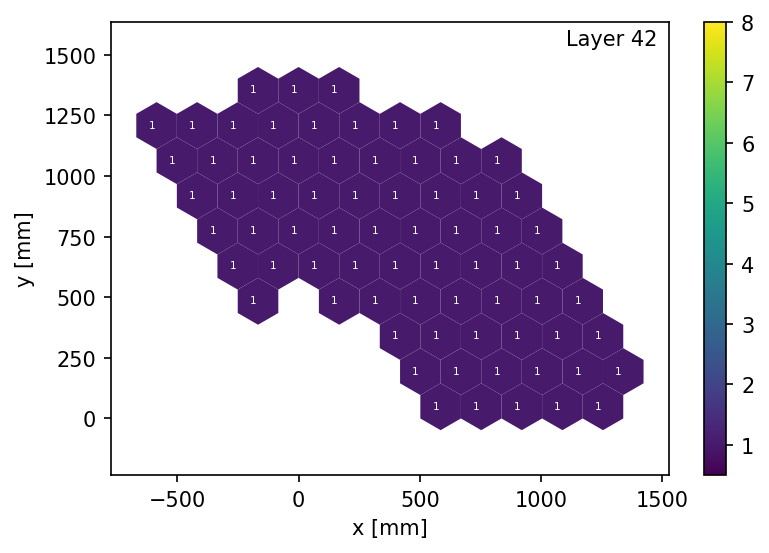

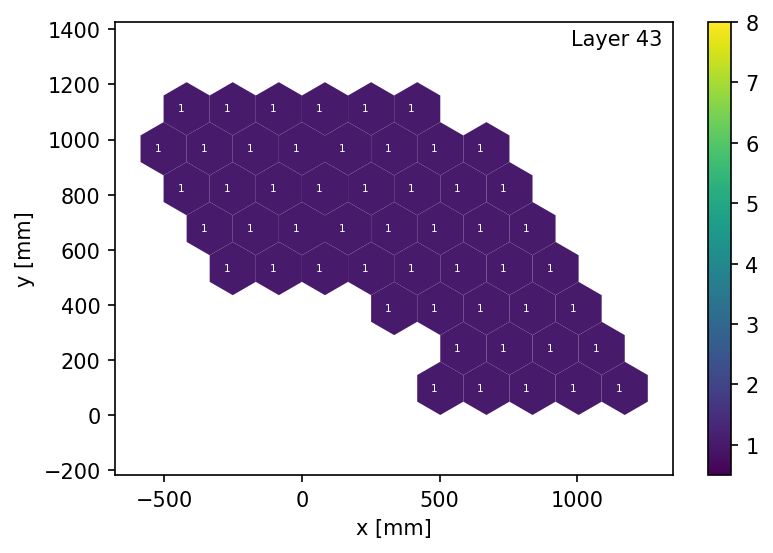

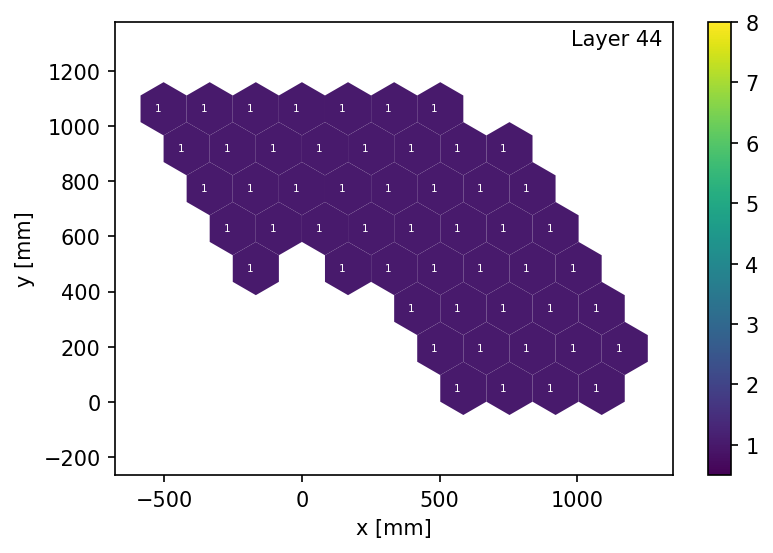

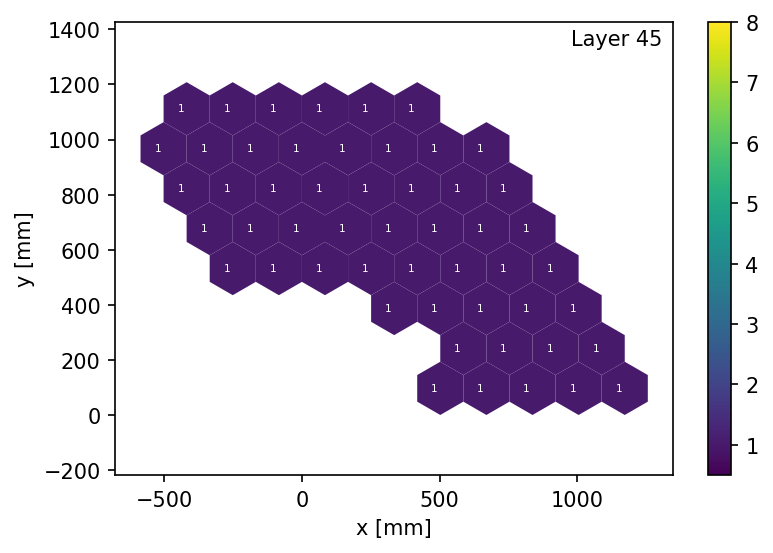

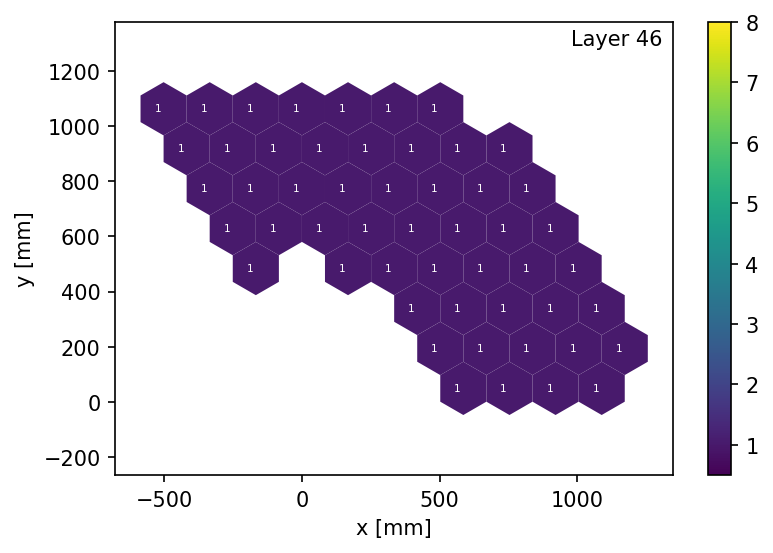

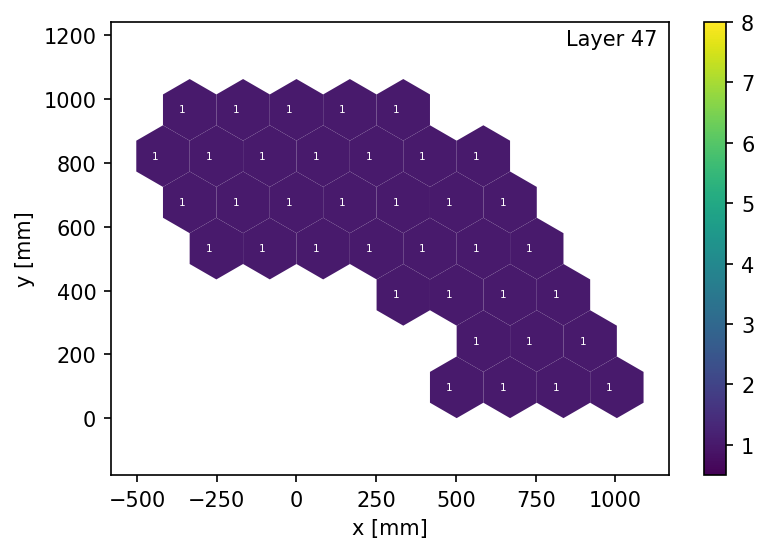

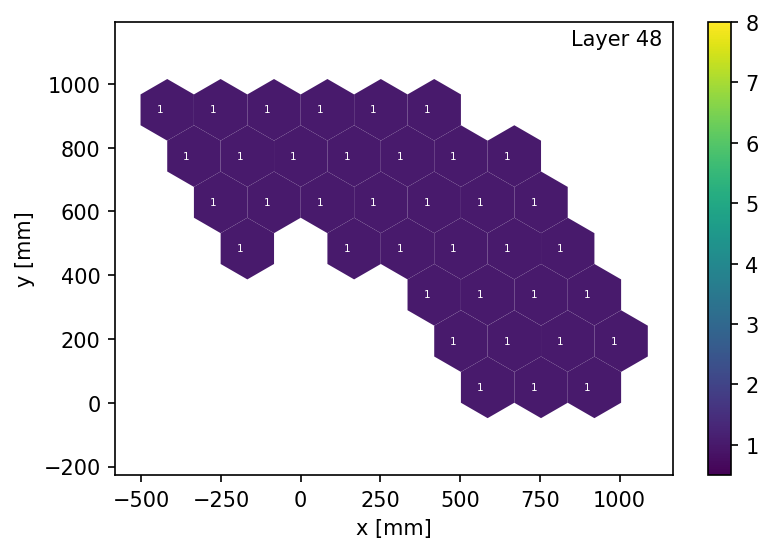

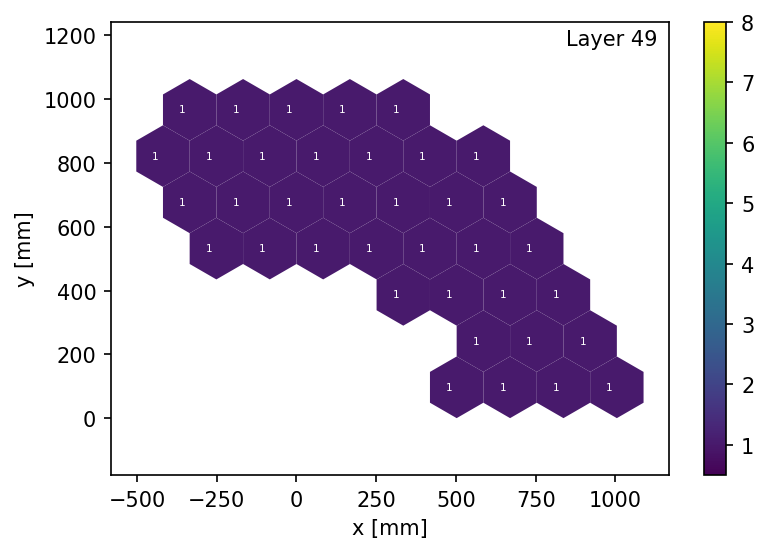

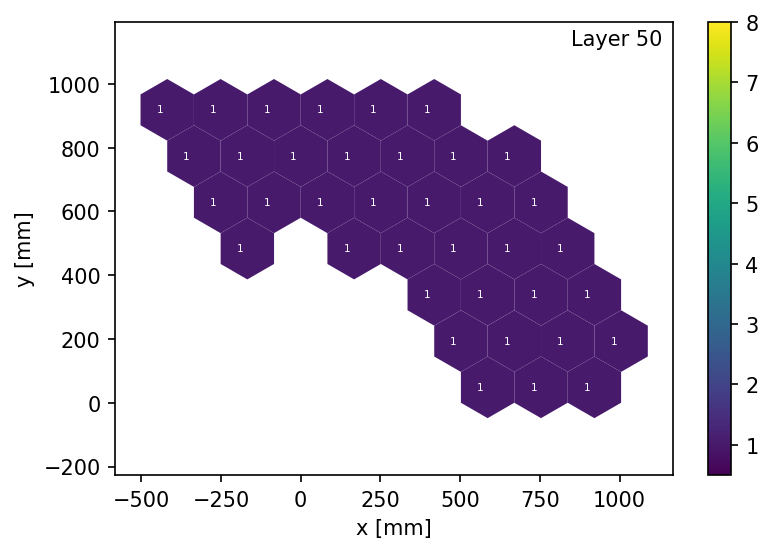

Empty DataFrame
Columns: []
Index: []

In [32]:
df.groupby('layer').apply(plot_sector_links)

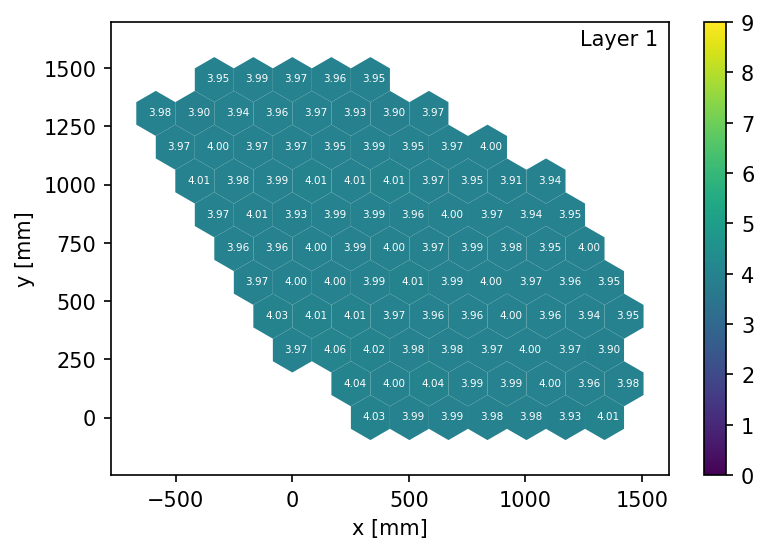

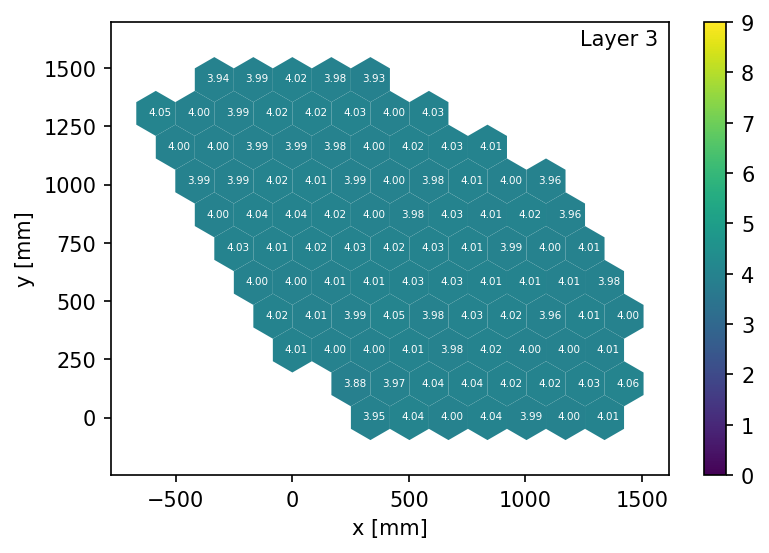

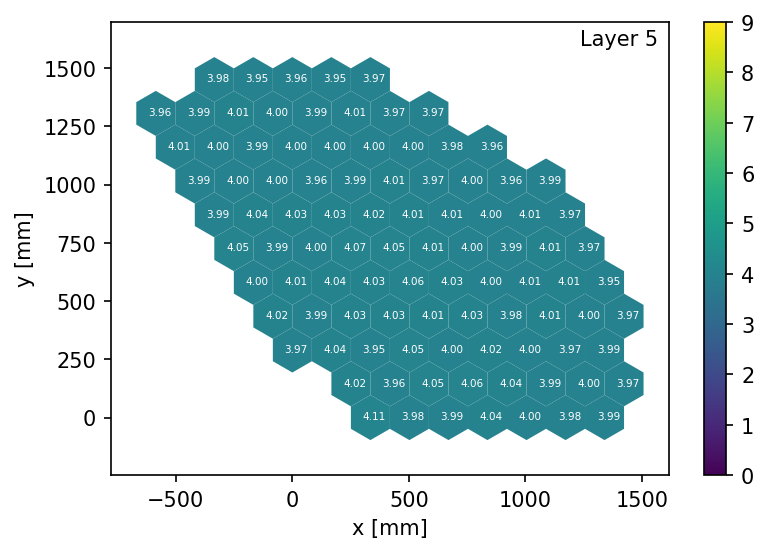

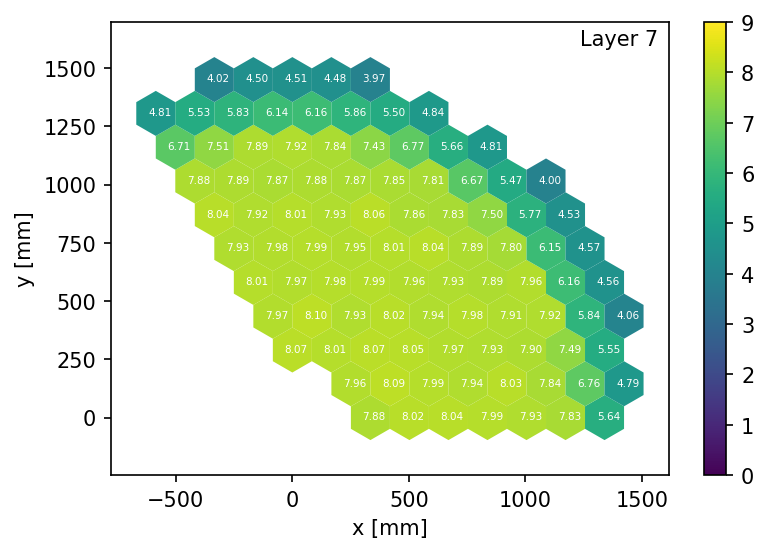

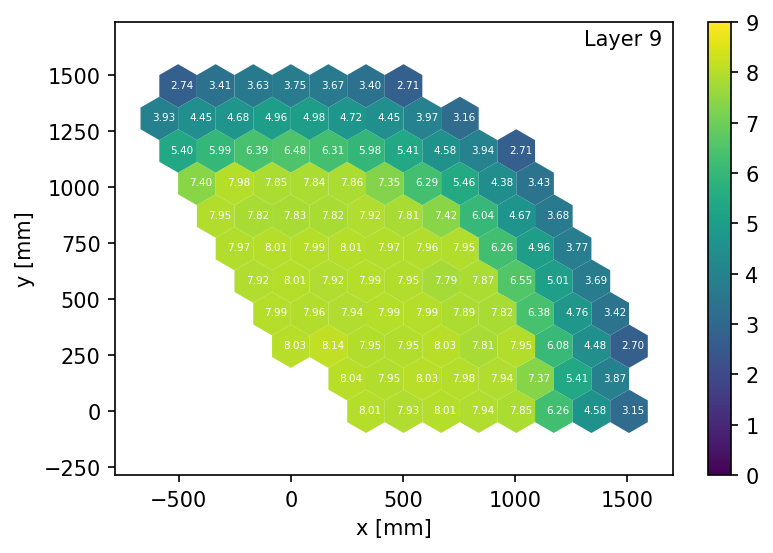

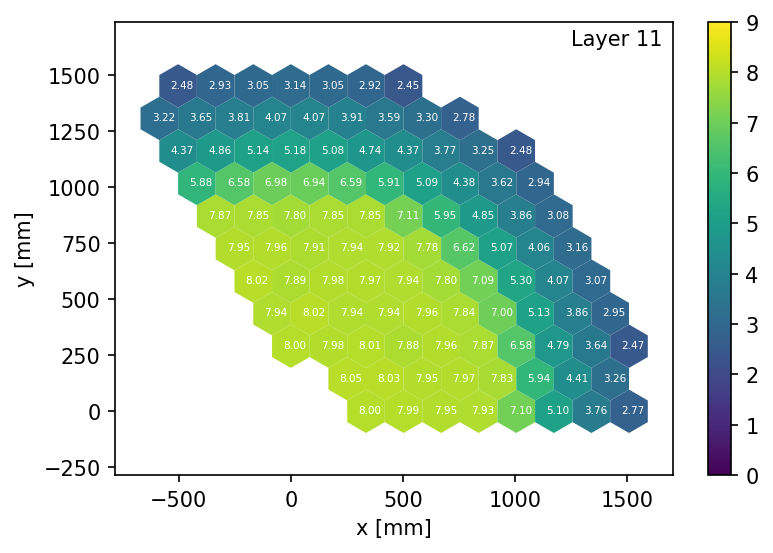

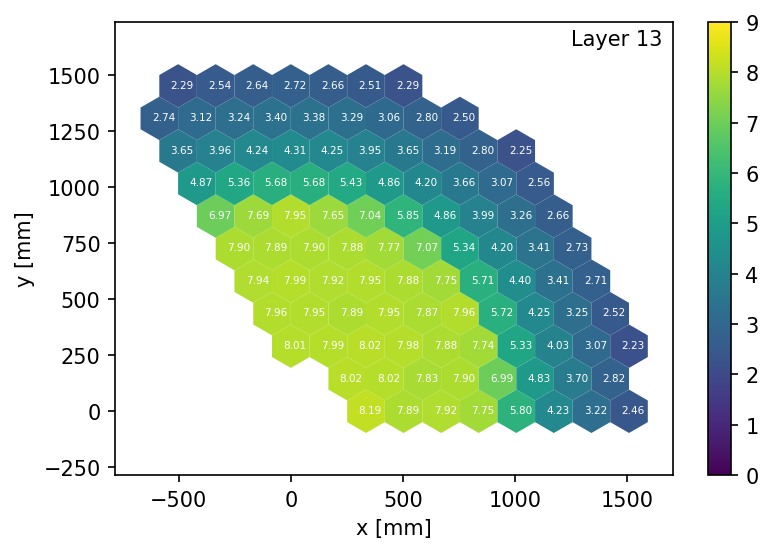

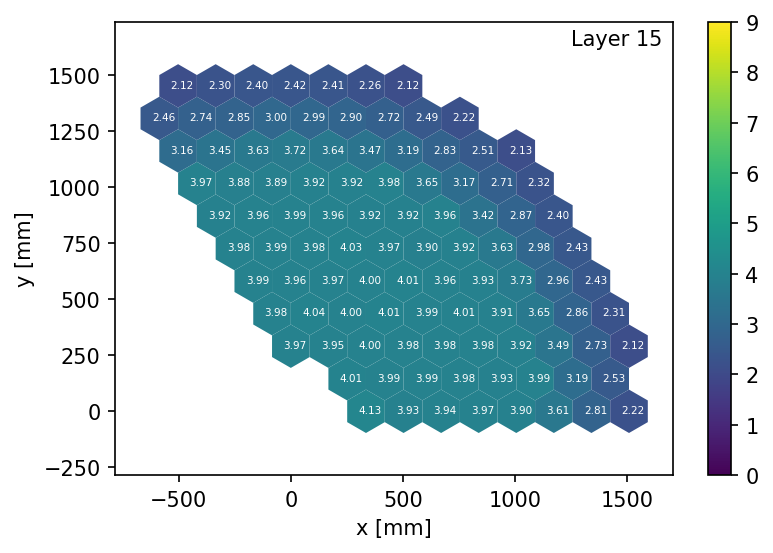

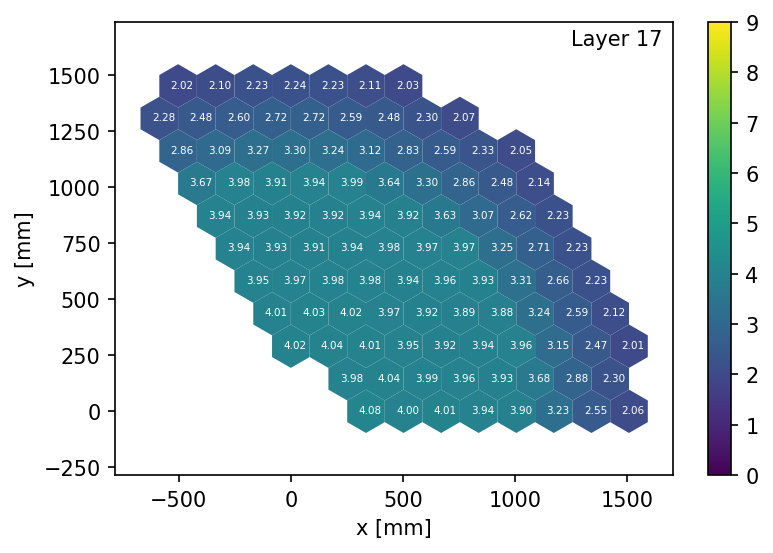

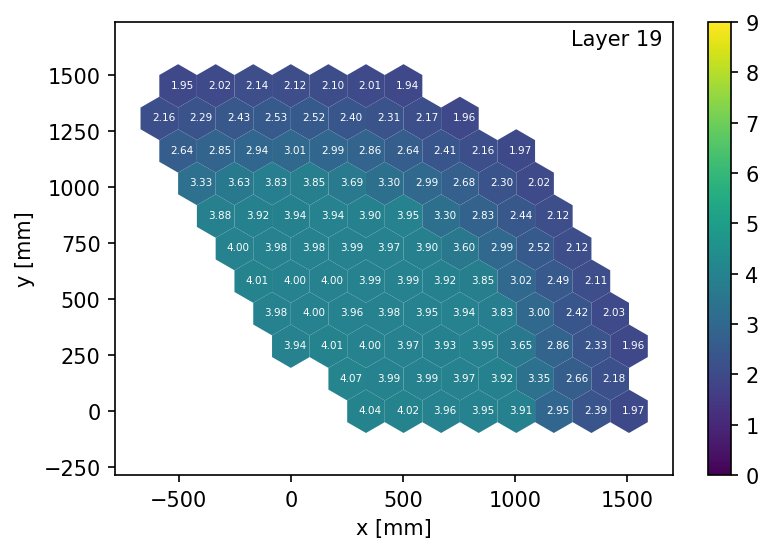

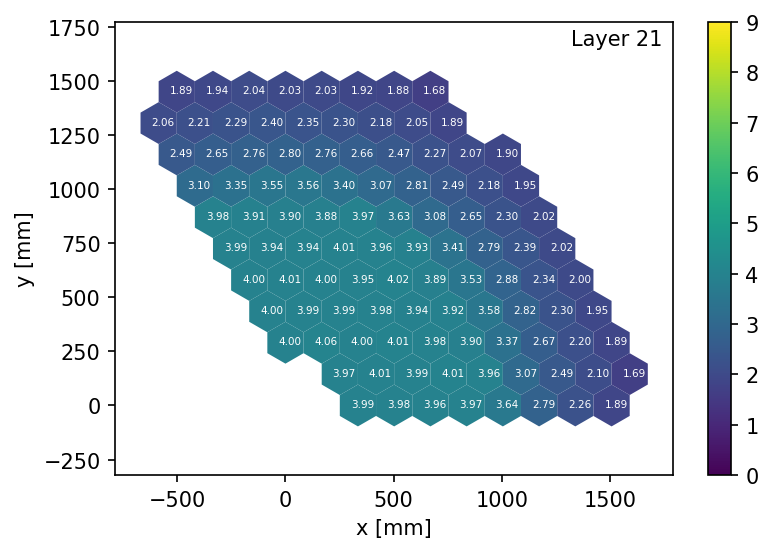

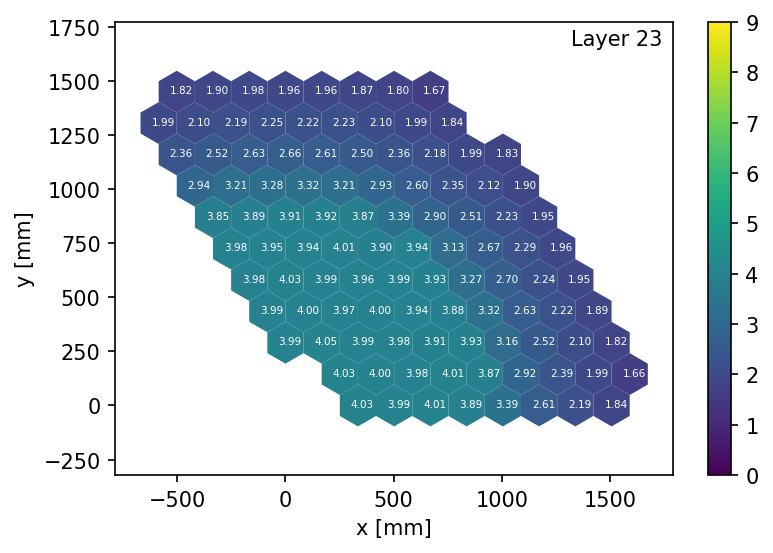

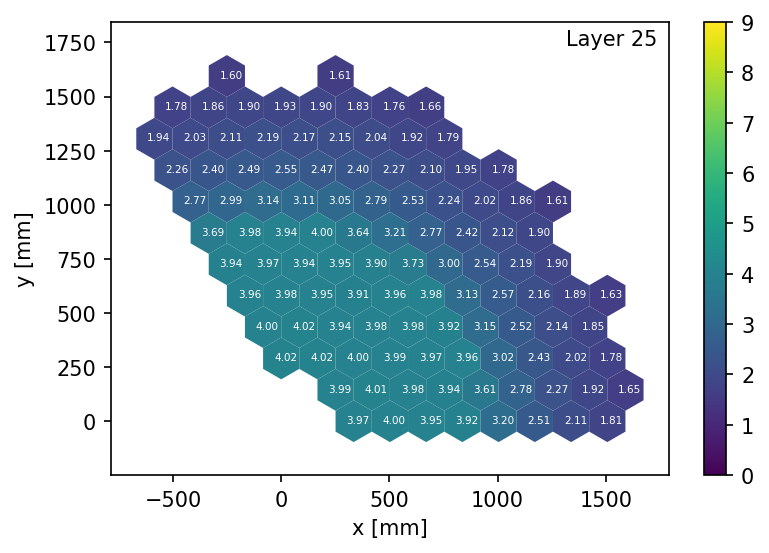

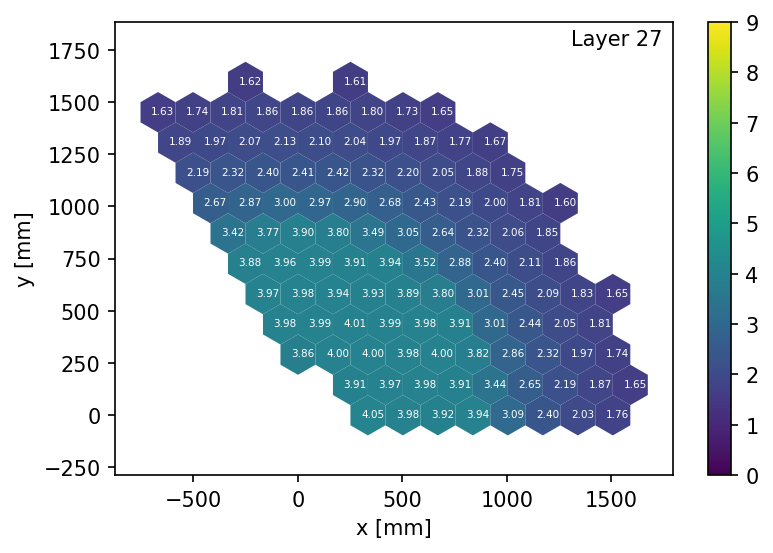

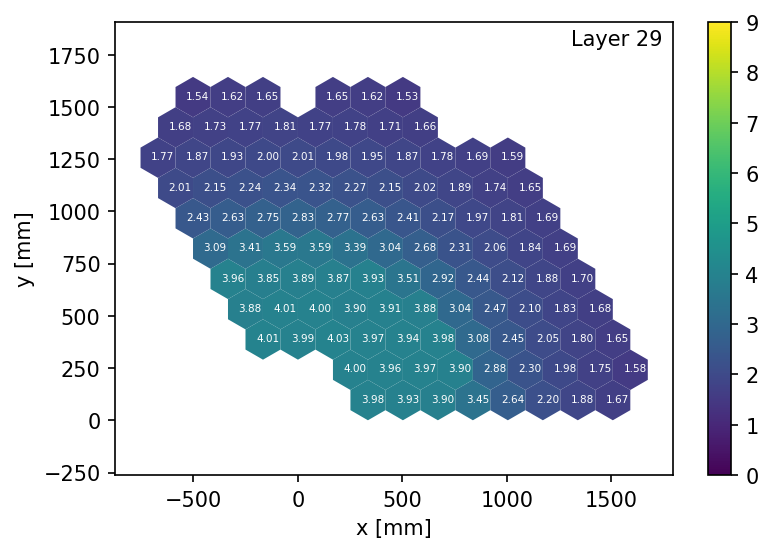

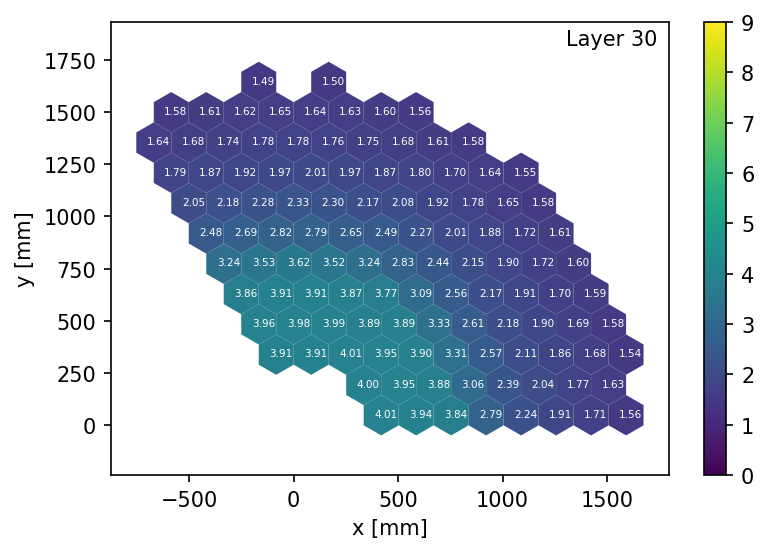

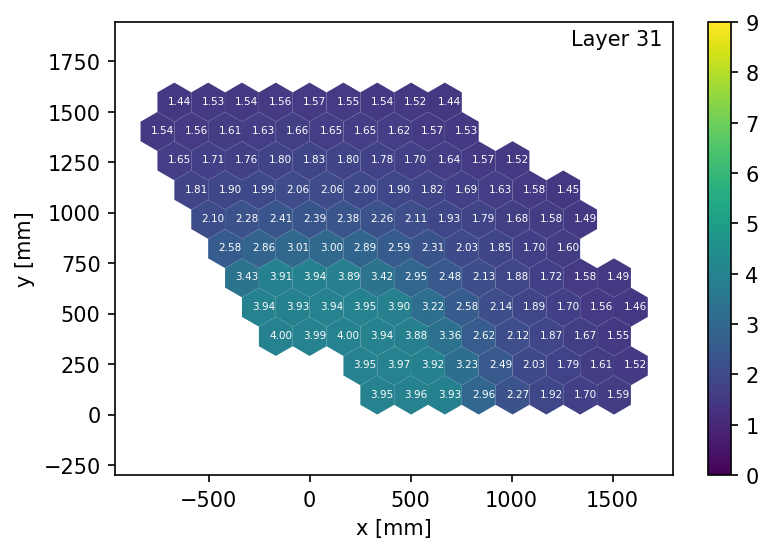

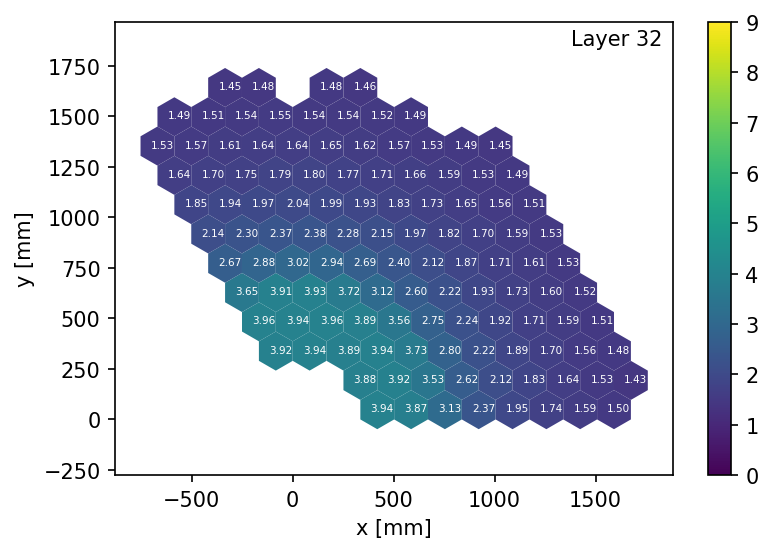

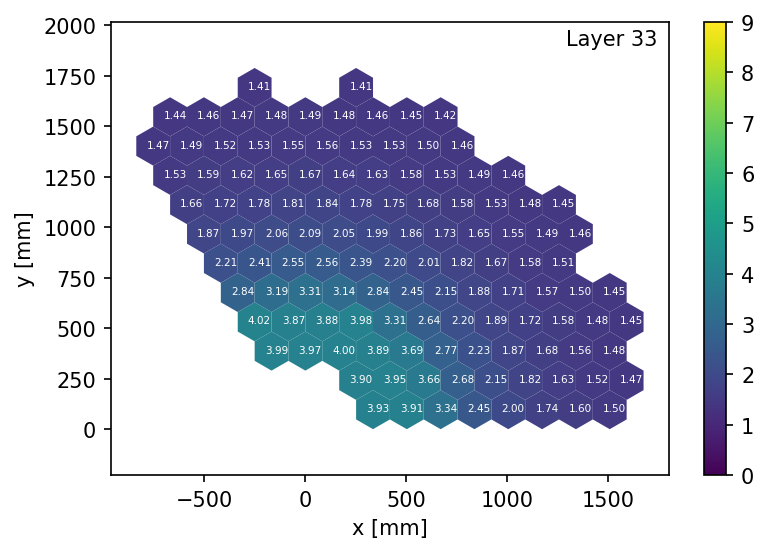

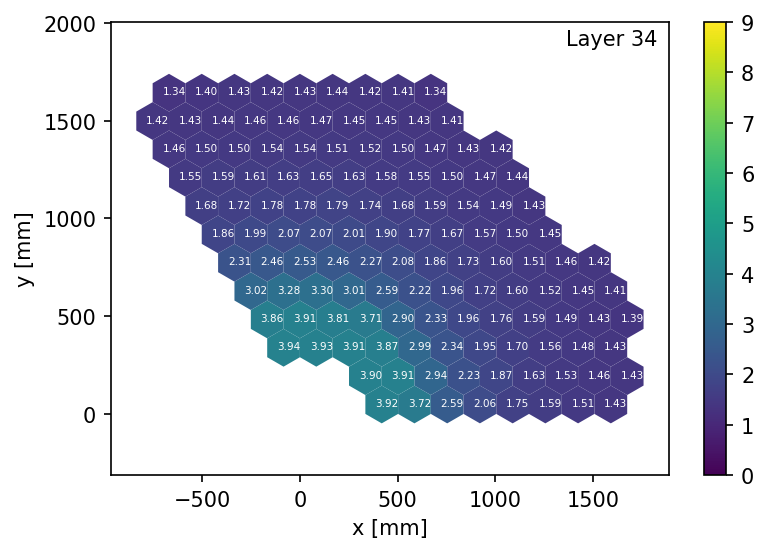

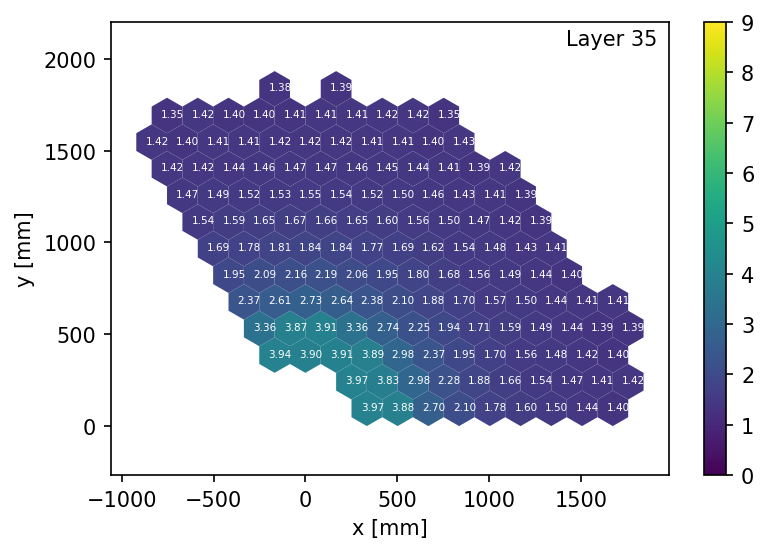

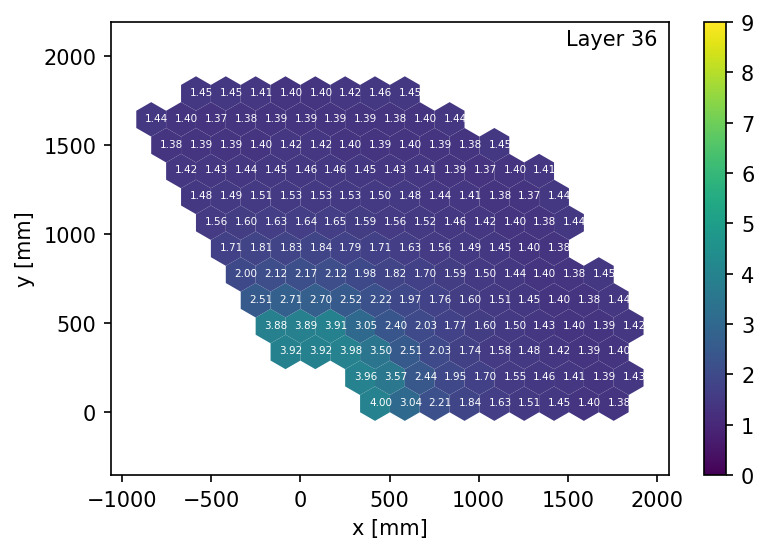

posx and posy should be finite values
posx and posy should be finite values


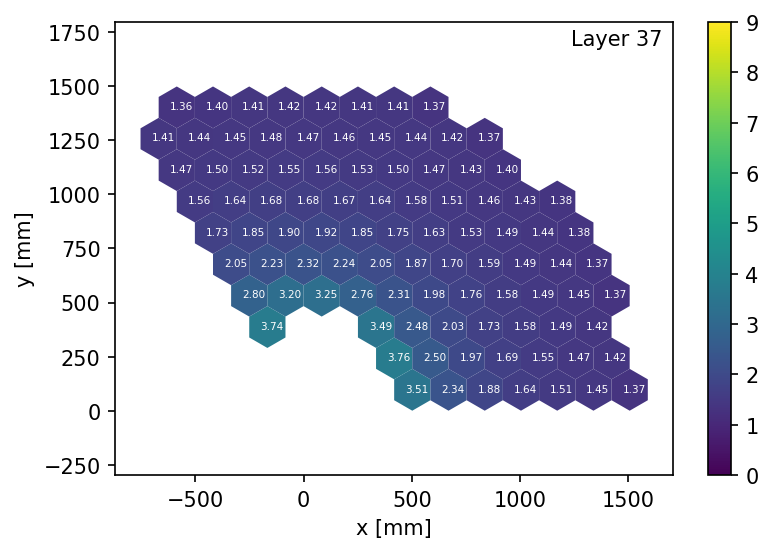

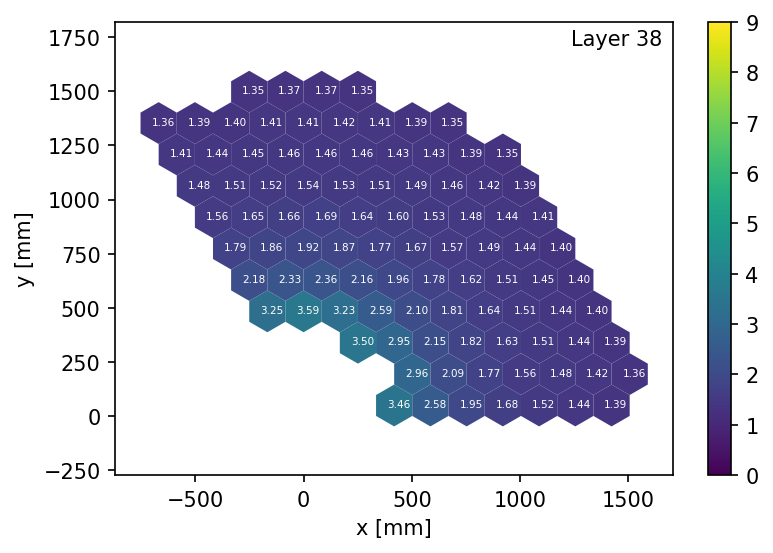

posx and posy should be finite values
posx and posy should be finite values


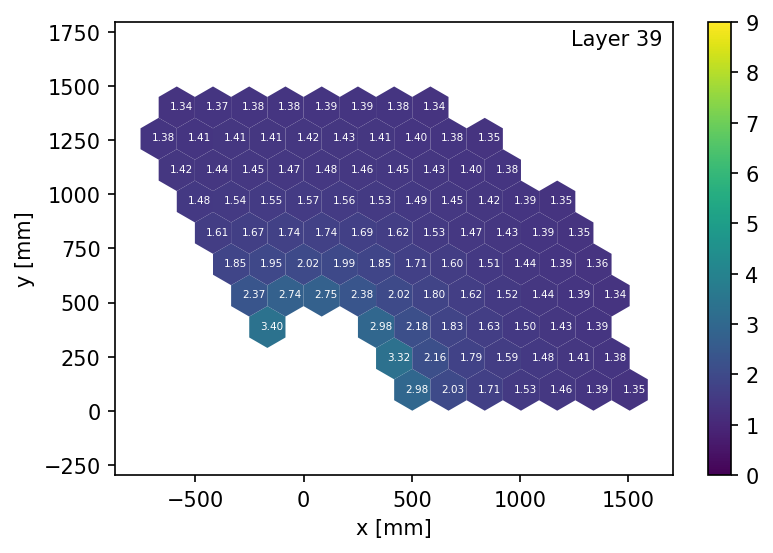

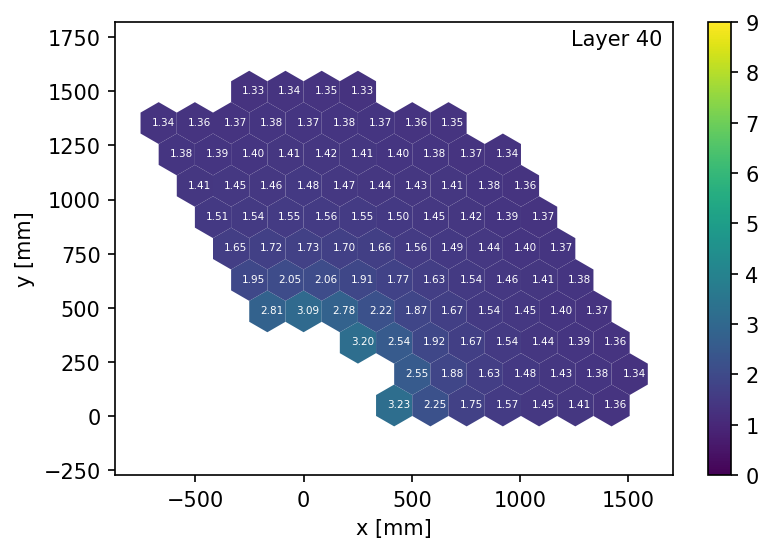

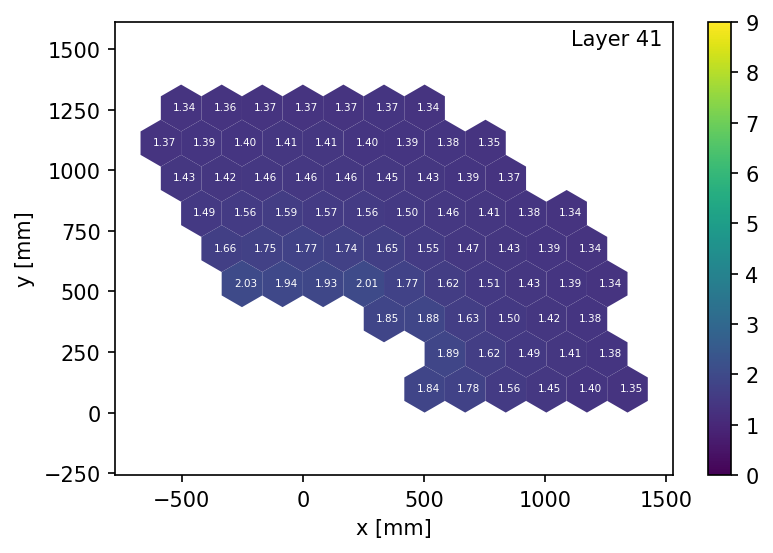

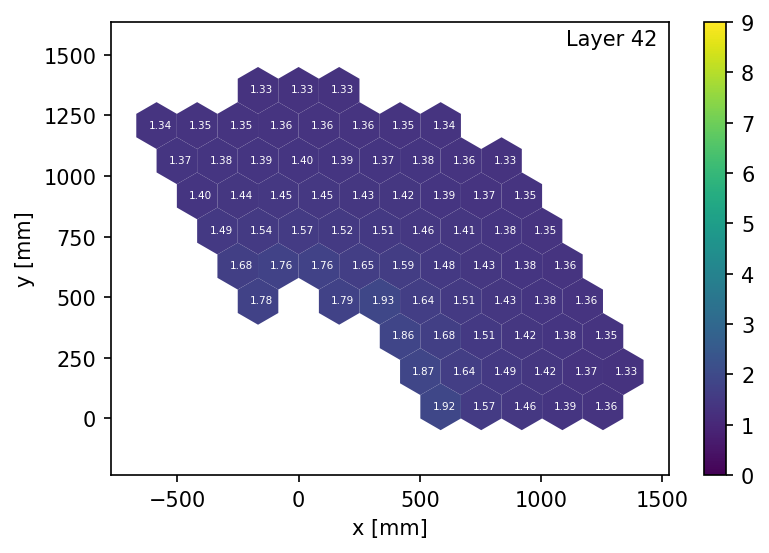

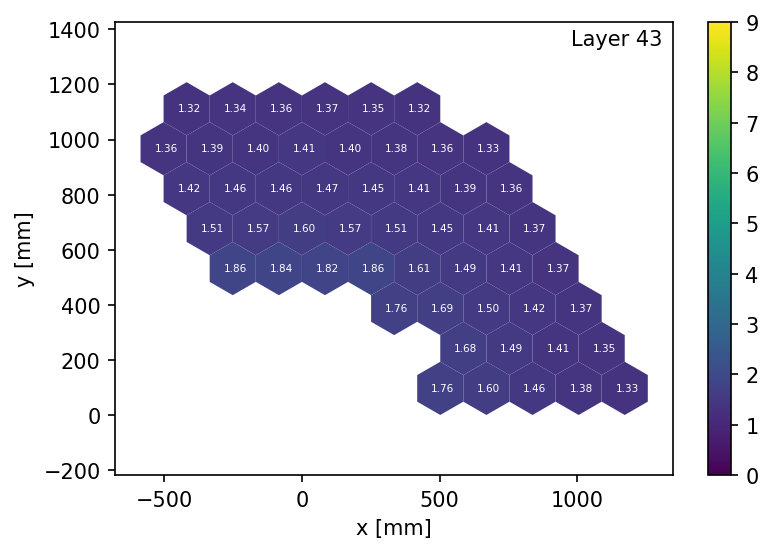

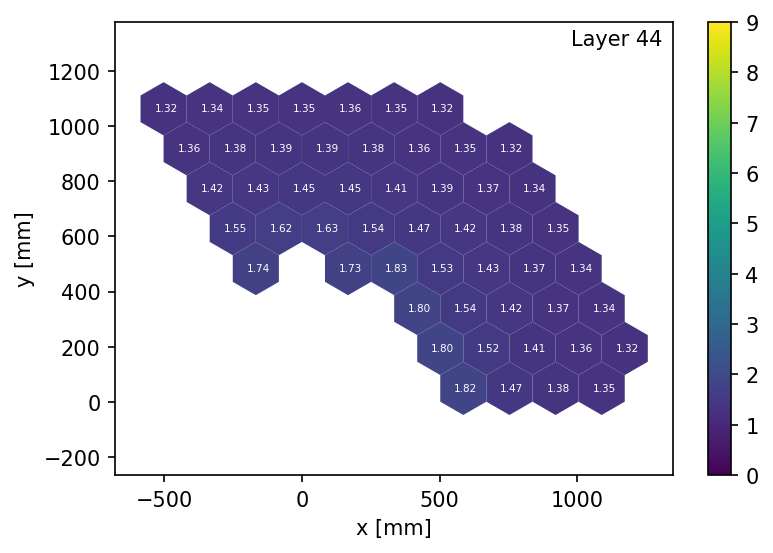

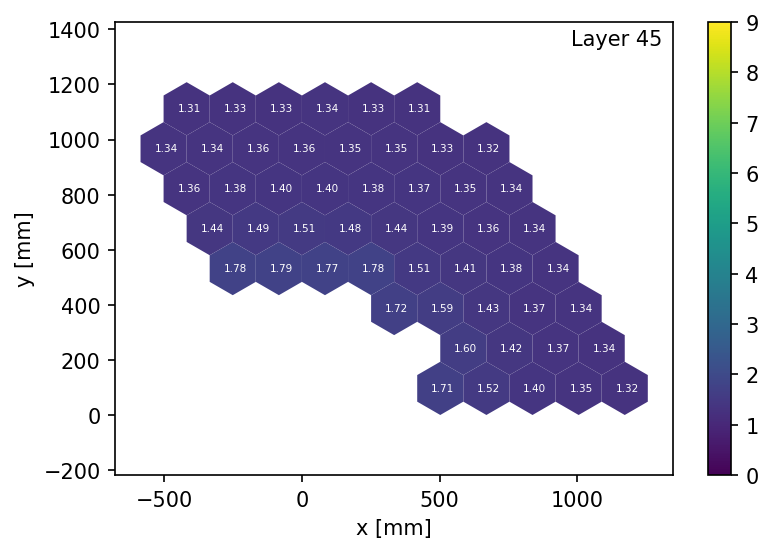

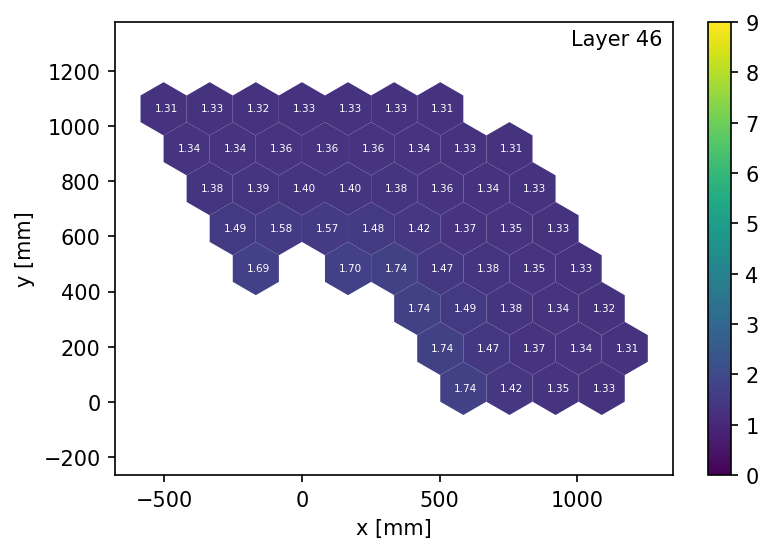

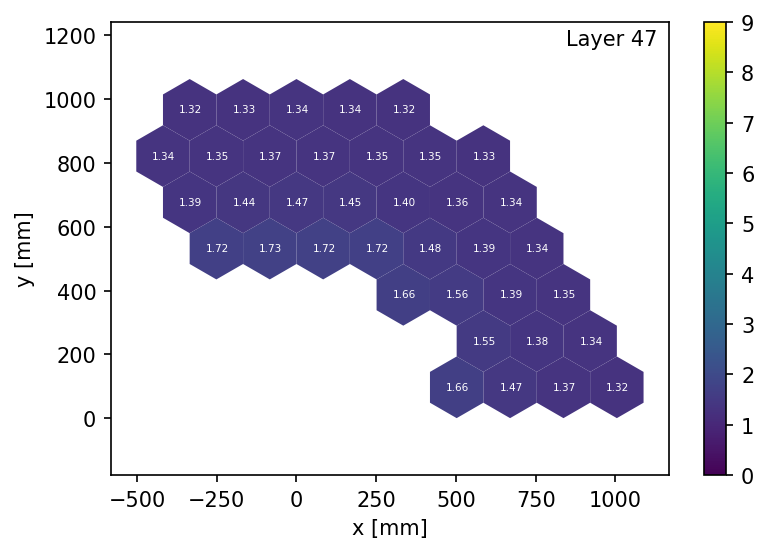

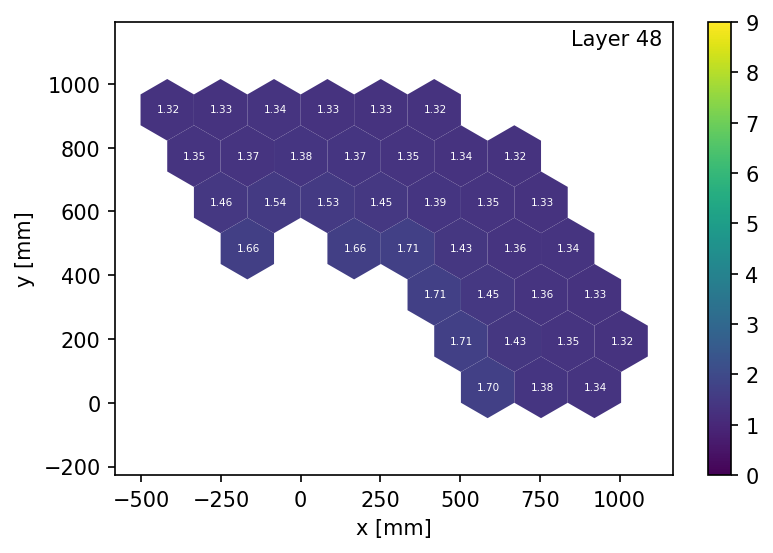

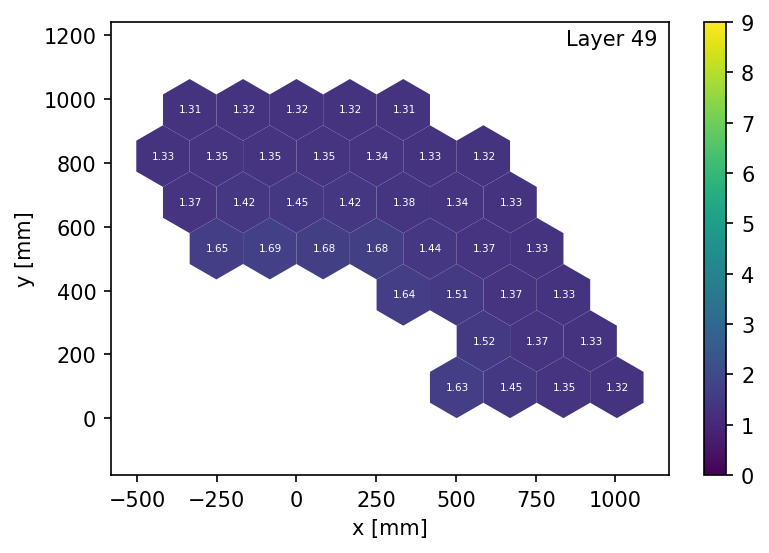

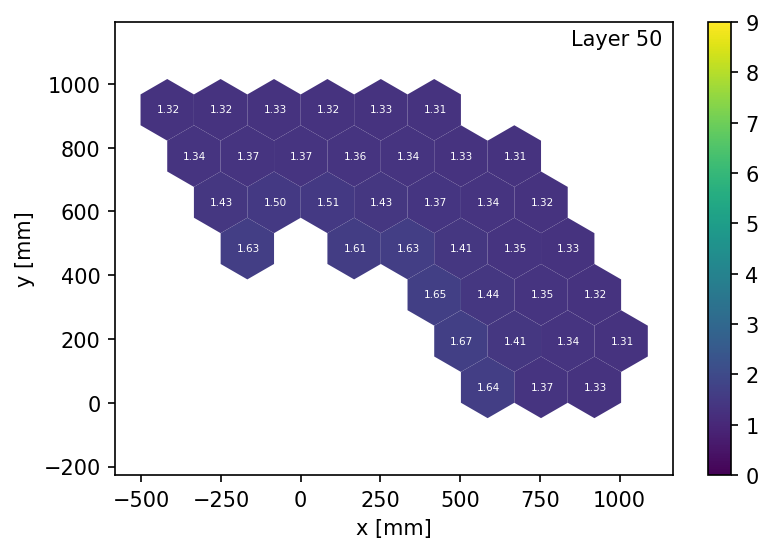

Empty DataFrame
Columns: []
Index: []

In [39]:
df.groupby('layer').apply(plot_sector_words)